# Pseudotime for GAMM pig retinal organoid sample

## First we use palantir to construct a pseudo time

In [53]:
# Palantir
# source .venv/bin/activate
# load packages

import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [54]:
# load data
## note- data was previously converted from seurat object to anndata object

data_dir = os.path.expanduser("/Users/bmoore/Desktop/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/")
adata = sc.read_h5ad(data_dir + "gamms2_clustifyr.h5ad")
adata

AnnData object with n_obs × n_vars = 19313 × 31781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'clustifyr_call_type', 'clustifyr_call_r', 'clustifyr_call_consol_type', 'clustifyr_call_consol_r', 'clustifyr_call_consol_hyper_type', 'clustifyr_call_consol_hyper_r', 'clustifyr_call_consol_jaccard_type', 'clustifyr_call_consol_jaccard_r', 'clustifyr_call_jaccard_type', 'clustifyr_call_jaccard_r', 'UMAP_1', 'UMAP_2', 'clustify_pred_type', 'clustify_pred_r'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [61]:
# WE have already preprocessed this data

# Now create a diffusion map

# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=6)
# low dim embedding of the data is estimated based on the eigen gap
ms_data = palantir.utils.determine_multiscale_space(adata)

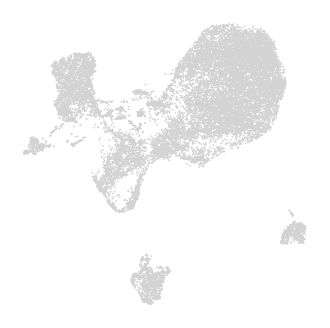

In [62]:
# visualize (note we have already done nearest neighbor and umap)
sc.pl.embedding(
    adata,
    basis="umap",
    frameon=False,
)

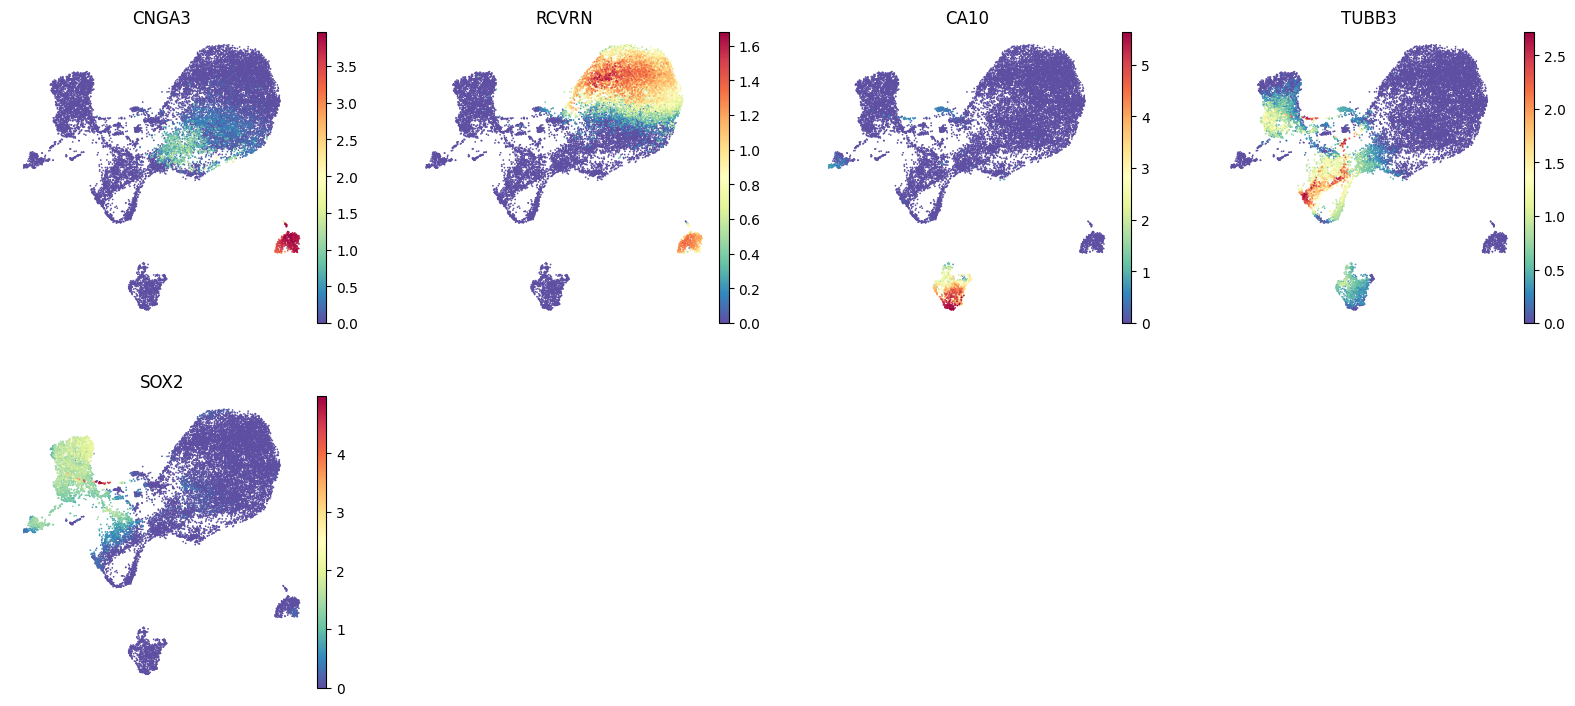

In [63]:
# MAGIC imputation
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imputed_X = palantir.utils.run_magic_imputation(adata)
# gene expression visualization on UMAP
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CNGA3", "RCVRN", "CA10", "TUBB3","SOX2"],
    frameon=False,
)
plt.show()

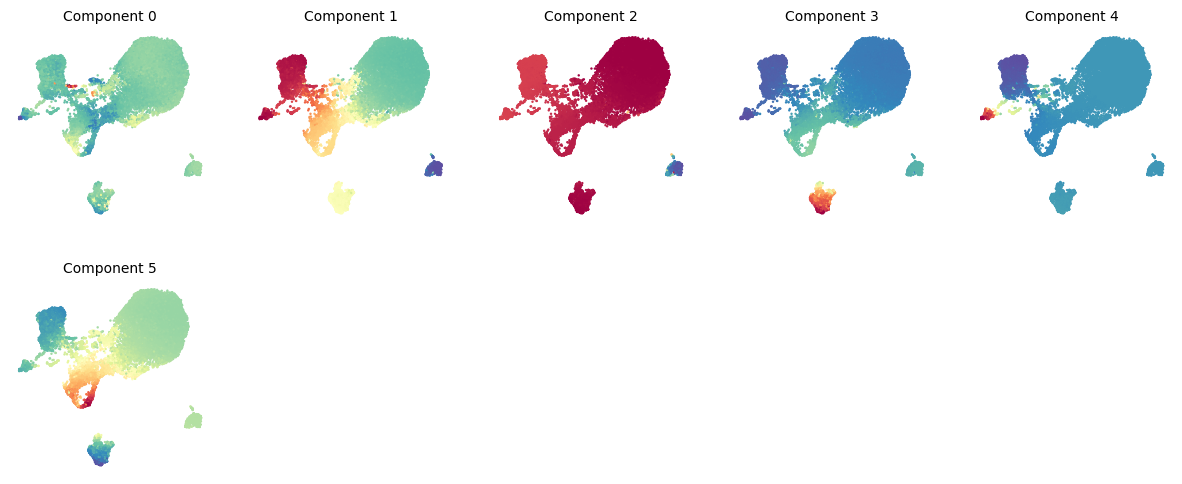

In [64]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(adata)
plt.show()

In [76]:
# find terminal states

# clustifyr
#set(adata.obs['clustifyr_call_consol_type'])
#palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs","Cones","Bipolar Cells", "Muller Glia"],celltype_column="clustifyr_call_consol_type")
# manual annotation
set(adata.obs['CellType'])
palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs-Rods","Cones-Pan PRs","Bipolar Cells", "Muller Glia","Ganglion cell","Bipolar Cells-Ganglion cell"],celltype_column="CellType")

Using CCTACGTAGCTTTCCC_1 for cell type Pan PRs-Rods which is max in diffusion component 1.
Using CCACGTTTCGCTTTAT_2 for cell type Cones-Pan PRs which is min in diffusion component 0.
Using TCAAGCATCACGATAC_1 for cell type Bipolar Cells-Ganglion cell which is max in diffusion component 2.


/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Bipolar Cells Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Bipolar Cells will be skipped.
  warn(
/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Muller Glia Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Muller Glia will be skipped.
  warn(
/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/palantir/utils.py:927: UserWarning: No valid component found: Ganglion cell Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type Ganglion cell will be skipped.
  warn(


CCTACGTAGCTTTCCC_1                   Pan PRs-Rods
CCACGTTTCGCTTTAT_2                  Cones-Pan PRs
TCAAGCATCACGATAC_1    Bipolar Cells-Ganglion cell
dtype: object

In [94]:
set(adata.obs['CellType'])

{'Bipolar Cells',
 'Bipolar Cells-Ganglion cell',
 'Cones-Pan PRs',
 'Ganglion cell',
 'Muller Glia',
 'Muller Glia-PanPRs-Rods',
 'NA',
 'Pan PRs',
 'Pan PRs-Rods',
 'Retinal Progenitor-Muller Glia',
 'unknown'}

In [77]:
# clustifyr
# use Retinal Prog to find start cell
#palantir.utils.early_cell(adata,celltype="Retinal Prog",celltype_column="clustifyr_call_consol_type")
# manual annotation
# use Retinal Progenitor-Muller Glia to find start cell
palantir.utils.early_cell(adata,celltype="Retinal Progenitor-Muller Glia",celltype_column="CellType")

Using GGTTCTCGTGTCTAAC_1 for cell type Retinal Progenitor-Muller Glia which is min in diffusion component 3.


'GGTTCTCGTGTCTAAC_1'

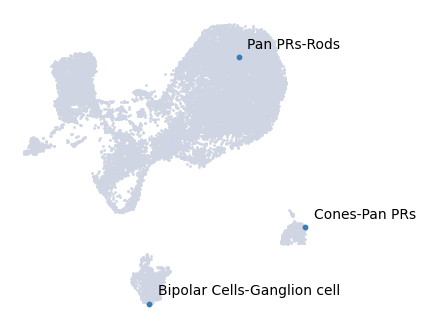

Sampling and flocking waypoints...
Time for determining waypoints: 0.003494819005330404 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.09767480293909708 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [78]:
# use cells found for start cell and terminal states for palantir analysis
# clustifyr
# terminal_states = pd.Series(
#     ["Pan PRs", "Cones", "Bipolar Cells"],
#     index=["CCTACGTAGCTTTCCC_1", "CCACGTTTCGCTTTAT_2", "TCAAGCATCACGATAC_1"],
# )
# manual annotation
terminal_states = pd.Series(
    ["Pan PRs-Rods", "Cones-Pan PRs", "Bipolar Cells-Ganglion cell"],
    index=["CCTACGTAGCTTTCCC_1", "CCACGTTTCGCTTTAT_2","TCAAGCATCACGATAC_1"],
)
palantir.plot.highlight_cells_on_umap(adata, terminal_states)
plt.show()

# Run Palantir
# clustifyr
#start_cell = "TTTCATGTCACCTTAT_2"
# manual annotation
start_cell = "GGTTCTCGTGTCTAAC_1"
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
)

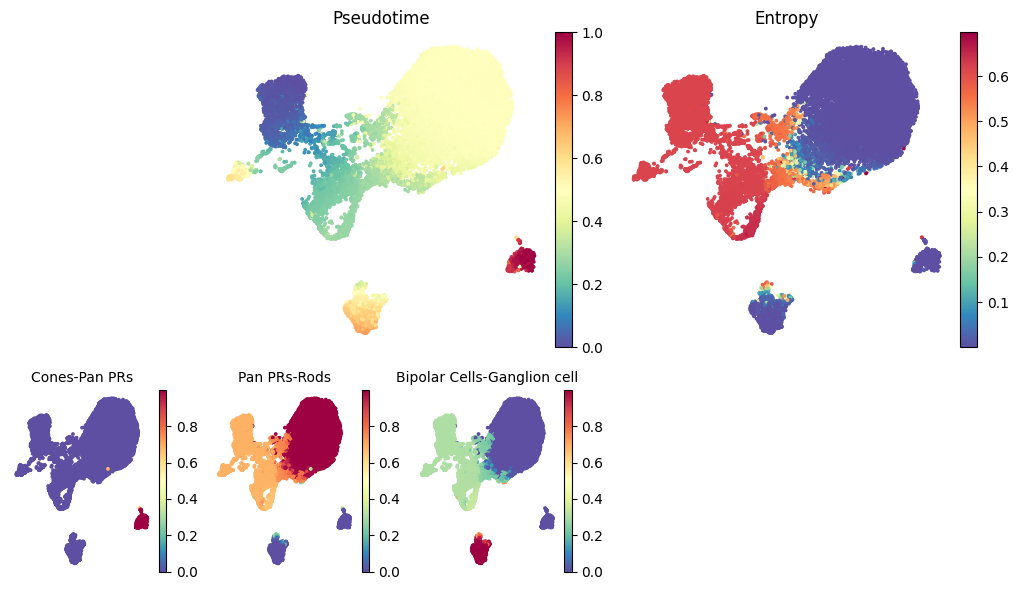

In [79]:
# plot results
palantir.plot.plot_palantir_results(adata, s=3)
plt.show()

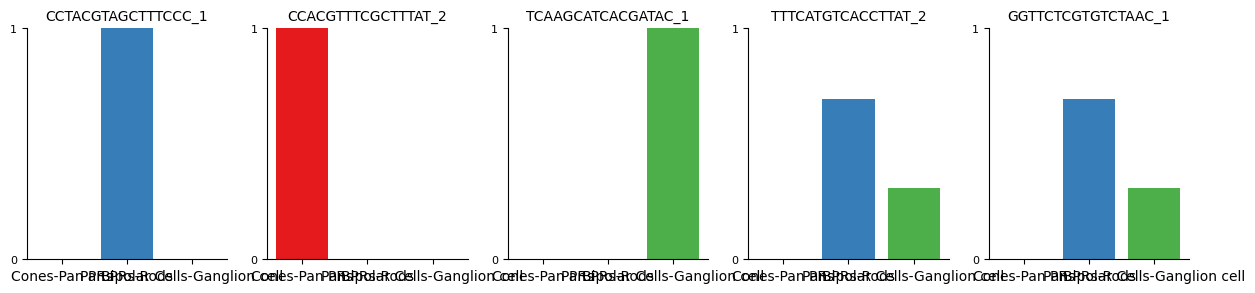

In [80]:
# Terminal state probability distributions of individual cells can be visualized using the plot_terminal_state_probs function
cells = [
    "CCTACGTAGCTTTCCC_1",
    "CCACGTTTCGCTTTAT_2",
    "TCAAGCATCACGATAC_1",
    "TTTCATGTCACCTTAT_2",
    "GGTTCTCGTGTCTAAC_1"
]
palantir.plot.plot_terminal_state_probs(adata, cells)
plt.show()

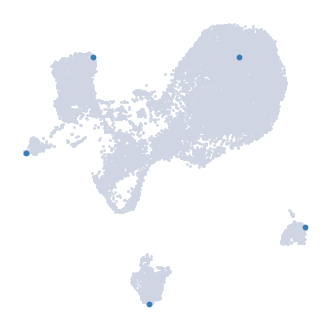

In [81]:
# highlight cells on UMAP
palantir.plot.highlight_cells_on_umap(adata, cells)
plt.show()

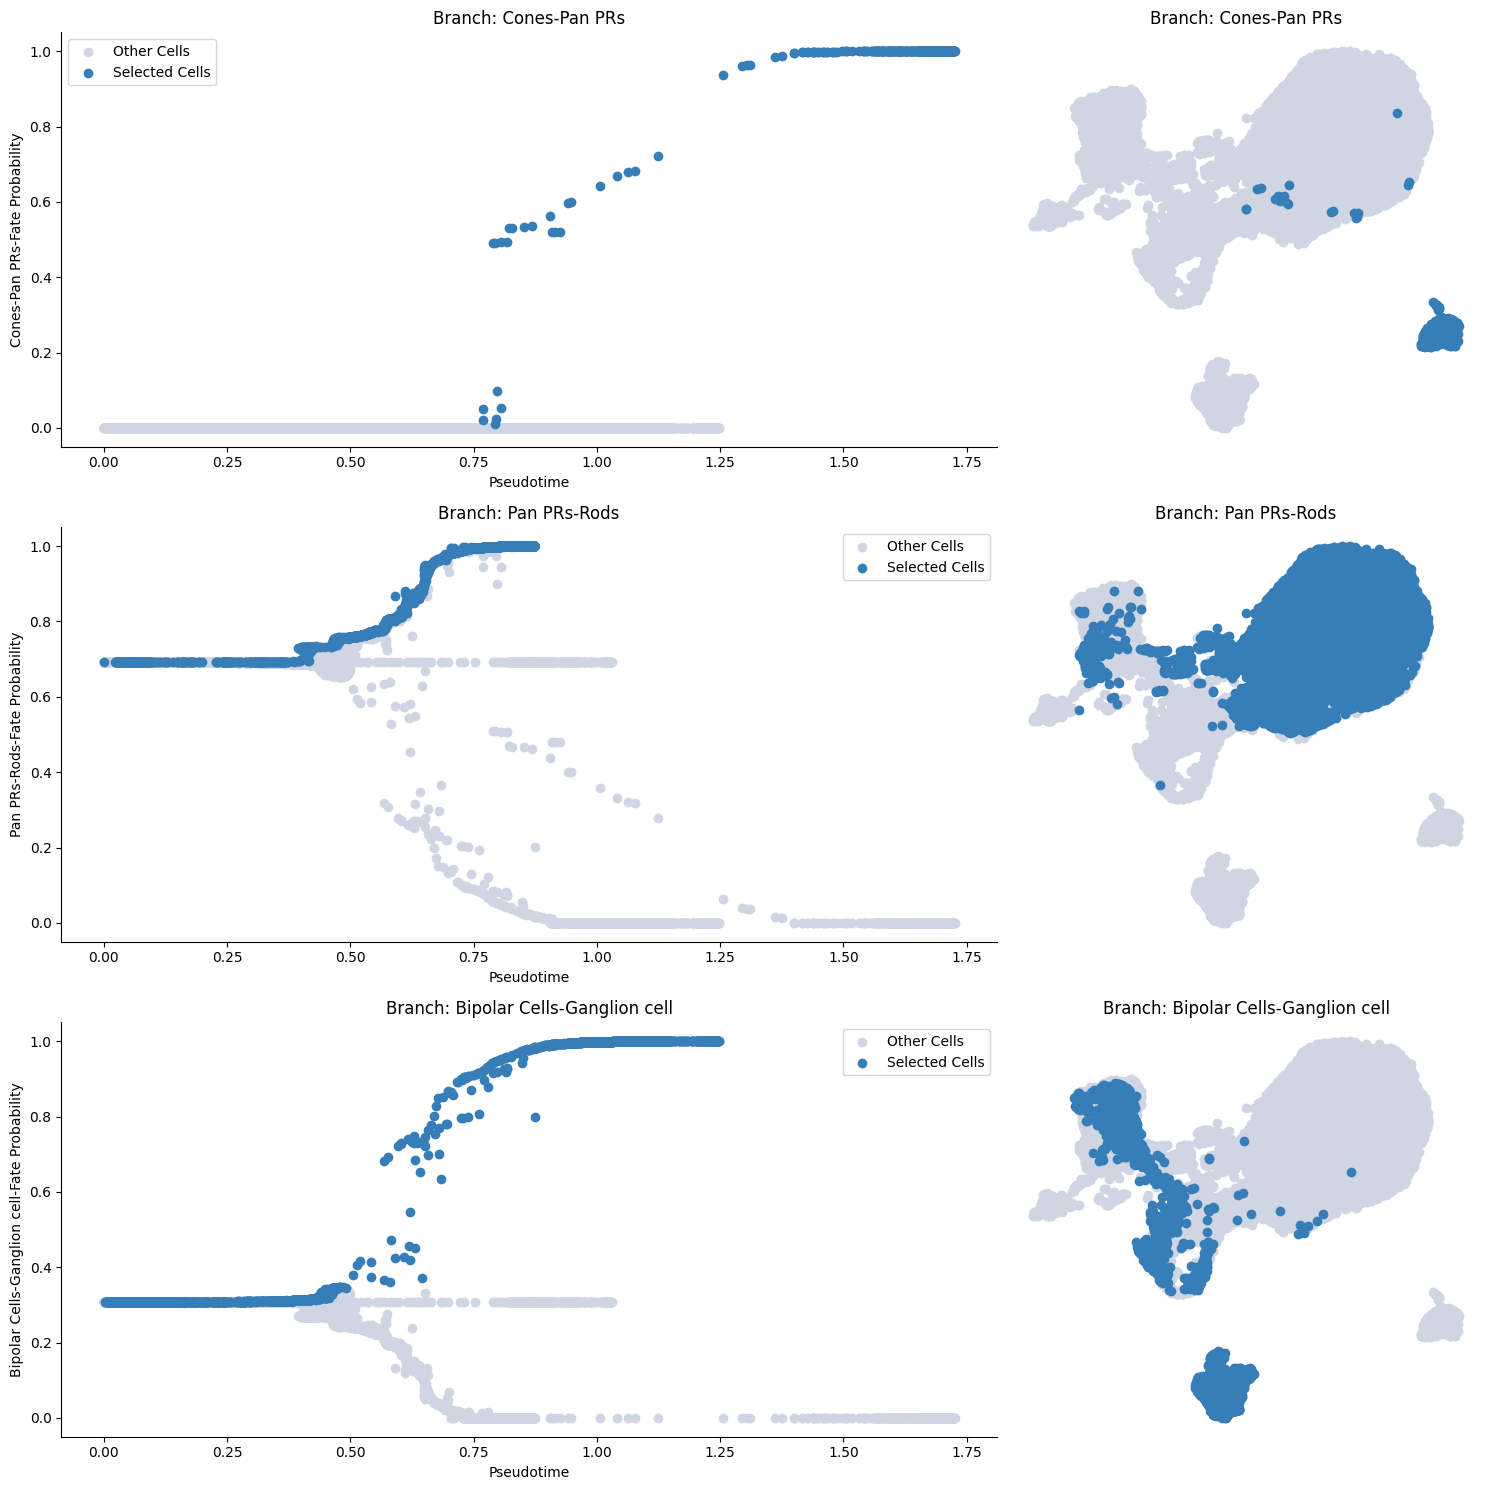

In [82]:
# Gene expression trends

# Select cells
# Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory.
masks = palantir.presults.select_branch_cells(adata, eps=0)
# visualize the branck selection
palantir.plot.plot_branch_selection(adata)
plt.show()

Cones-Pan PRs
[2023-10-16 11:51:57,699] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (536) and rank = 1.0.
[2023-10-16 11:51:57,700] [INFO    ] Using covariance function Matern52(ls=1.0).
Pan PRs-Rods
[2023-10-16 11:52:01,700] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (11,485) and rank = 1.0.
[2023-10-16 11:52:01,703] [INFO    ] Using covariance function Matern52(ls=1.0).
Bipolar Cells-Ganglion cell
[2023-10-16 11:52:07,260] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (2,578) and rank = 1.0.
[2023-10-16 11:52:07,261] [INFO    ] Using covariance function Matern52(ls=1.0).


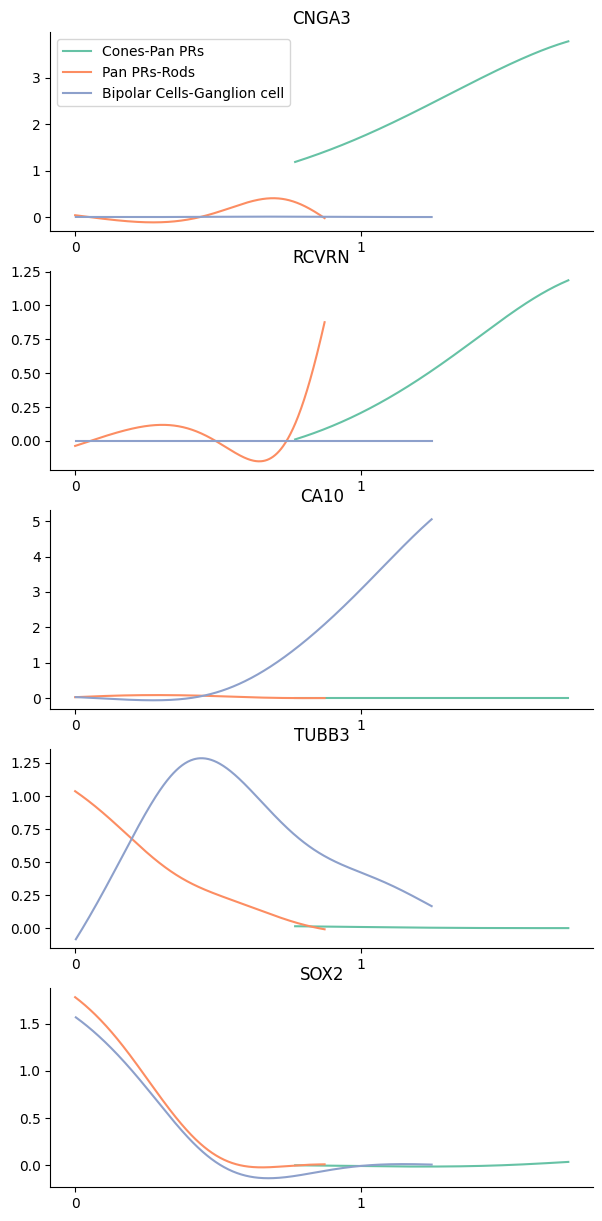

In [83]:
# Determine marker gene trends using the  Mellon Function Estimator
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)
# visualize trends
genes = ["CNGA3", "RCVRN", "CA10", "TUBB3","SOX2"]
palantir.plot.plot_gene_trends(adata, genes)
plt.show()

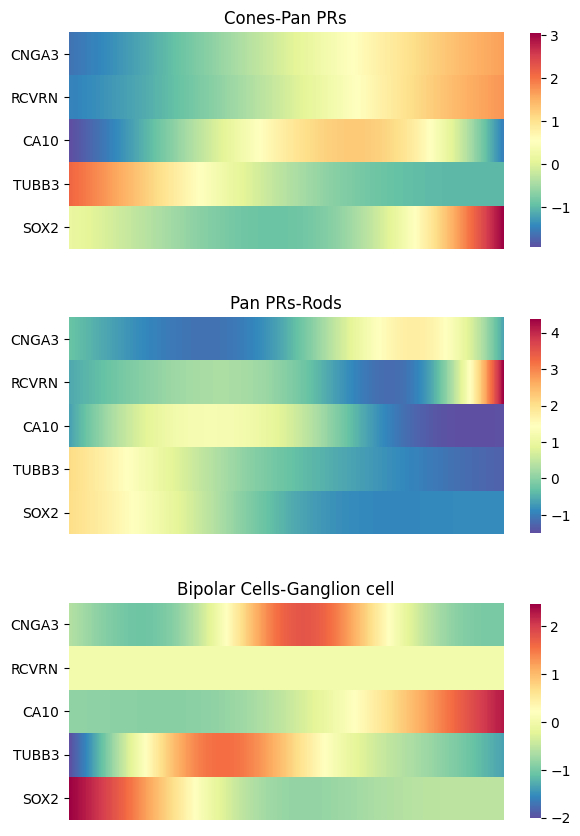

In [84]:
# Heatmap trend visualization
palantir.plot.plot_gene_trend_heatmaps(adata, genes)
plt.show()

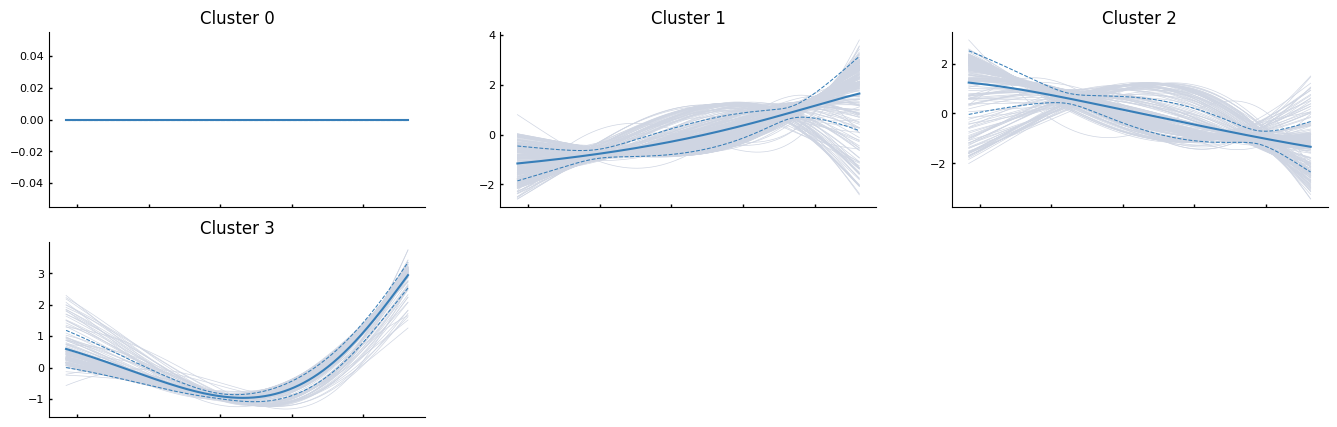

In [85]:
# Clustering
# Gene expression trends can be clustered and visualized
# Here the first 1000 genes along the cones genes are clustered
more_genes = adata.var_names[:1000]
# clustifyr
# communities = palantir.presults.cluster_gene_trends(adata, "Cones", more_genes)
# palantir.plot.plot_gene_trend_clusters(adata, "Cones")
# manual annotation
communities = palantir.presults.cluster_gene_trends(adata, "Cones-Pan PRs", more_genes)
palantir.plot.plot_gene_trend_clusters(adata, "Cones-Pan PRs")
plt.show()

In [86]:
adata
# weird seurat to anndata thing- anndata doesn not like a column named _index
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [87]:
import numpy as np
import cellrank as cr
import scanpy as sc
import scvelo as scv
# compute diffusion pseudotime (DPT)
# start by computing a diffusion map
# need to recompute nearest neighbots first
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.diffmap(adata)

In [88]:
# find root cell
adata.obsm['X_diffmap'][:, 3].argmax()

9853

/Users/bmoore/Desktop/scRNAseq/.venv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


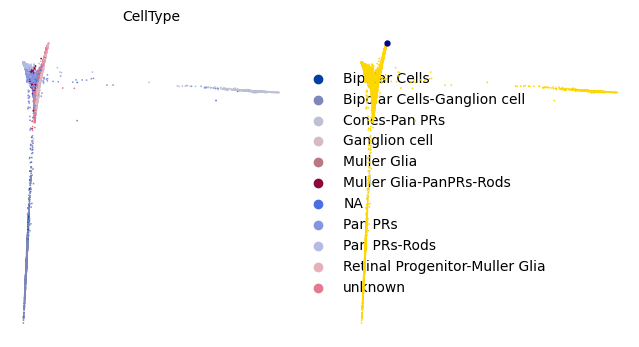

In [92]:
# visualize and set root
root_ixs = 9853  # has been found using `adata.obsm['X_diffmap'][:, 3].argmax()`
scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['CellType', root_ixs], # clustifyr_call_consol_type
    legend_loc="right",
    components=["2, 3"],
)

adata.uns["iroot"] = root_ixs

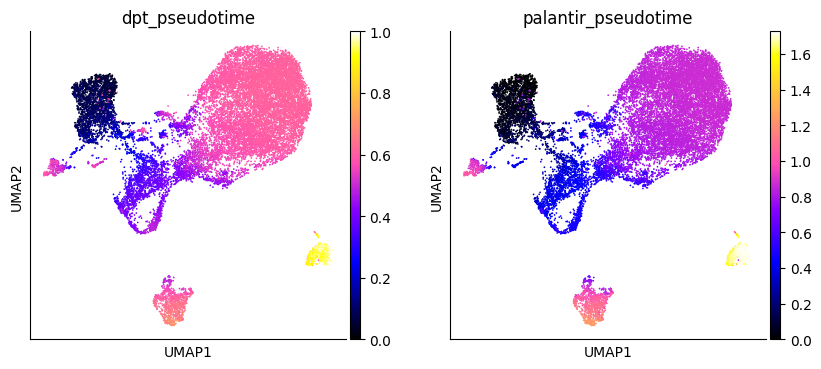

In [93]:
# Once we found a root cell we’re happy with (a cell from the HSC cluster), we can compute DPT and compare it with the precomputed Palantir pseudotime:
sc.tl.dpt(adata)
sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

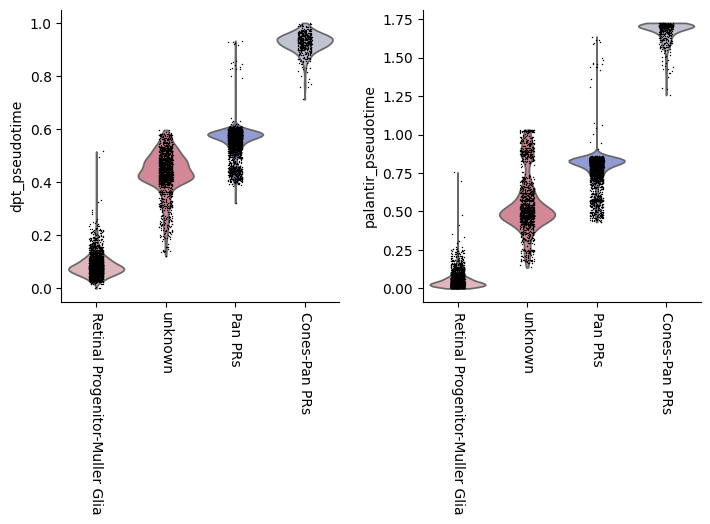

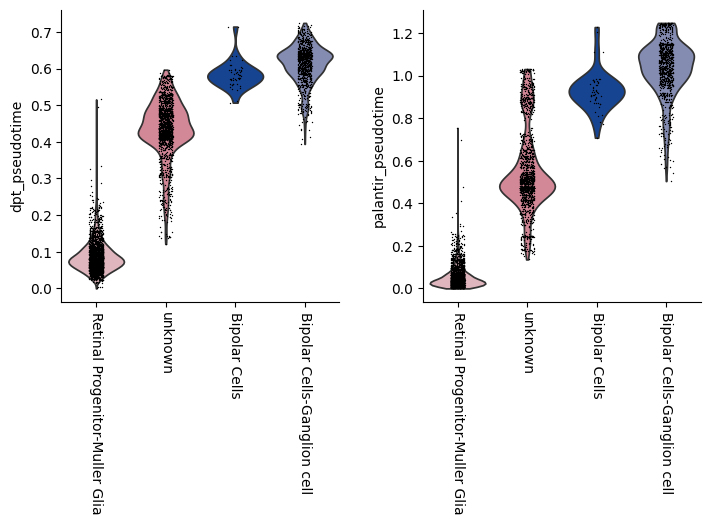

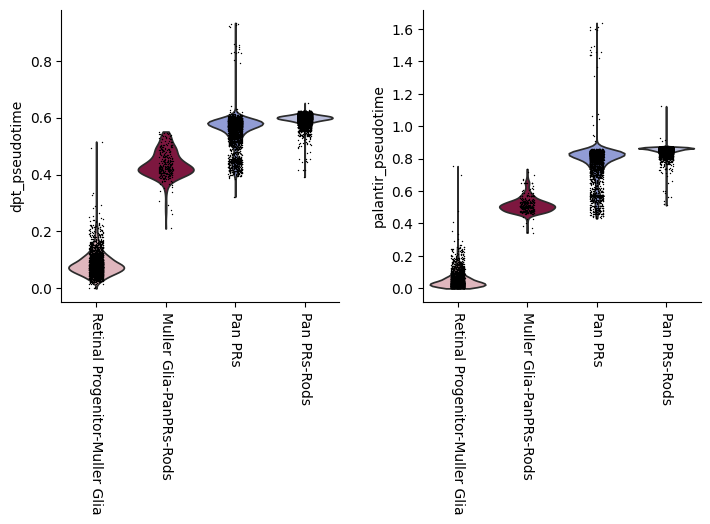

In [95]:
# plot trajectory
cone_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Pan PRs","Cones-Pan PRs"] #["Retinal Prog", "Pan PRs", "Cones"]
bipolar_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Bipolar Cells","Bipolar Cells-Ganglion cell"] #["Retinal Prog", "Muller Glia", "Bipolar Cells"]
rod_trajectory = ["Retinal Progenitor-Muller Glia","Muller Glia-PanPRs-Rods","Pan PRs","Pan PRs-Rods"] #["Retinal Prog", "Pan PRs", "Pan PRs-Rods"]

# plot the cone trajectory
mask = np.in1d(adata.obs["CellType"], cone_trajectory) # clustifyr_call_consol_type
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="CellType",                                # clustifyr_call_consol_type
    rotation=-90,
    order=cone_trajectory,
)

# plot the bipolar trajectory
mask = np.in1d(adata.obs["CellType"], bipolar_trajectory) # clustifyr_call_consol_type
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="CellType",                           # clustifyr_call_consol_type
    rotation=-90,
    order=bipolar_trajectory,
)

# plot the rod trajectory
mask = np.in1d(adata.obs["CellType"], rod_trajectory) 
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="CellType",                          
    rotation=-90,
    order=rod_trajectory,
)

In [96]:
# Compute a transition matrix based on Palantir pseudotime
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

print(pk)

100%|██████████| 19313/19313 [00:01<00:00, 12266.62cell/s]


PseudotimeKernel[n=19313]


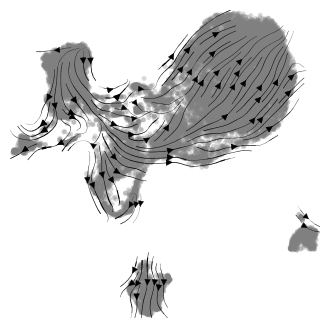

In [97]:
# visualize based on pseudotime and transition matrix
pk.plot_projection(basis="umap", recompute=True)

In [98]:
# Save results
file_path = os.path.join(data_dir, "GAMMS2_pseudotime_processed.h5ad")
adata.write(file_path)
# package versions
import pkg_resources

for package in pkg_resources.working_set:
    print(package.key, pkg_resources.get_distribution(package).version)

fsspec 2023.9.2
xarray 2023.9.0
certifi 2023.7.22
pytz 2023.3.post1
tzdata 2023.3
setuptools 65.5.0
pyzmq 25.1.1
pip 23.2.1
packaging 23.2
attrs 23.1.0
contextlib2 21.6.0
rich 13.6.0
websockets 11.0.3
pillow 10.0.1
ipython 8.16.1
natsort 8.4.0
jupyter-client 8.4.0
click 8.1.7
ipykernel 6.25.2
deepdiff 6.6.0
tornado 6.3.3
importlib-resources 6.1.0
multidict 6.0.4
pyyaml 6.0.1
traitlets 5.11.2
psutil 5.9.5
jupyter-core 5.4.0
decorator 5.1.1
tzlocal 5.1
tqdm 4.66.1
fonttools 4.43.1
protobuf 4.24.4
beautifulsoup4 4.12.2
typing-extensions 4.8.0
pexpect 4.8.0
gdown 4.7.1
progressbar2 4.2.0
ordered-set 4.1.0
readchar 4.0.5
async-timeout 4.0.3
cmake 3.27.6
zipp 3.17.0
filelock 3.12.4
platformdirs 3.11.0
h5py 3.10.0
aiohttp 3.8.6
python-utils 3.8.1
matplotlib 3.7.1
anyio 3.7.1
rpy2 3.5.14
idna 3.4
charset-normalizer 3.3.0
opt-einsum 3.3.0
threadpoolctl 3.2.0
inquirer 3.1.3
pyparsing 3.1.1
networkx 3.1
prompt-toolkit 3.0.39
loompy 3.0.7
cython 3.0.3
jinja2 3.0.3
markdown-it-py 3.0.0
requests 2.3